In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [766]:
loan_result = pd.read_csv('data/loan_result.csv')
# log_data = pd.read_csv('data/log_Data.csv')
user_spec = pd.read_csv('data/user_spec.csv')

In [767]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
# log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯
 

## loan_result.csv 전처리

In [768]:
loan_result_test_drop = loan_result[(loan_result['승인한도'].isnull())&(loan_result['신청_여부(y)'].isnull())]
loan_result_train_drop = loan_result[(loan_result['승인한도'].isnull())&(loan_result['신청_여부(y)'].notnull())]

In [769]:
loan_result.drop(loan_result_test_drop.index,inplace = True)
loan_result.drop(loan_result_train_drop.index,inplace = True)
loan_result.reset_index(inplace =True,drop = True)

## user_spec.csv

user_spec에는 있지만 loan_result에 없는경우: drop

In [770]:
user_spec.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_spec.reset_index(drop = True,inplace = True)

loan_result에 있지만 user_spec에 없는 신청서_번호:drop
- 모두 신청이 된 상품(test 데이터가 아님)
- 승인한도, 승인금리가 없음



In [771]:
drop_list = list(set(user_spec['신청서_번호'])-set(loan_result['신청서_번호']))
user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
user_spec.reset_index(drop = True,inplace = True)

## 유저_번호 전처리
- 각 유저들이 몇번을 신용조회를 통해 대출비교를 했는지 count하여 파생변수 만들기

In [772]:
user_spec['대출비교횟수'] = user_spec.groupby('유저_번호')['유저_번호'].transform('count')

## 유저_생년월일&유저_성별 전처리
- 유저 생년월일과 null인 데이터는 유저 성별도 null값이다.(신청서 기준 8593개) 
    - 우선 유저 성별이 없는 데이터 중 다른 신청서에 성별과 생년월일이 있다면 그 값으로 대체
    - test data에 해당하는 신청서를 제외한 성별&생년월일이 없는 신청서들은 drop

In [773]:
# 유저 성별이 다른 신청서에는 있지만 결측치가 있는 유저들 처리
sex_null_list = set(user_spec[(user_spec['유저_번호'].isin(set(user_spec[user_spec['유저_성별'].isnull()]['유저_번호'])))&(user_spec['유저_성별'].notnull())]['유저_번호'])
for i in sex_null_list:
    user_spec.loc[(user_spec['유저_번호']==i)&(user_spec['유저_생년월일'].isnull()),'유저_생년월일'] = user_spec[user_spec['유저_번호'] ==i]['유저_생년월일'].dropna().unique().item()
    user_spec.loc[(user_spec['유저_번호']==i)&(user_spec['유저_성별'].isnull()),'유저_성별'] = user_spec[user_spec['유저_번호'] ==i]['유저_성별'].dropna().unique().item()

In [774]:
user_list = set(user_spec[user_spec['유저_성별'].isnull()]['신청서_번호'])# 유저 생년월일&성별이 없는 유저들의 신청서 번호
application_list = set(loan_result[(loan_result['신청_여부(y)'].isnull())&(loan_result['신청서_번호'].isin(user_list))]['신청서_번호']) # test_data중 생년월일,성별이 없는 유저들의 신청서 
drop_list = user_list - application_list# test에 해당안하는 성별과 생년월일이 없는 유저들의 신청서_번호 list

user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
user_spec.reset_index(drop = True,inplace = True)

-------------------------------------

## 한도조회_당시_유저_신용점수 전처리
- 25%는 신용점수가 없음
- 신용점수등급에 따라 점수대를 구분한다.
- 신용점수가 없는 유저들은 0점으로 대체
    - 신용점수 대체를 어떻게 할것인가 논의
    - 신용점수가 소득보다 대출금상환, 신용카드와 관련된 항목 -> 기대출수, 기대출금액상환
    - 신용점수등급과 연소득은 비례 -> 연소득

In [775]:
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

In [776]:
bins = [-2, 0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
labels = ['null', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
user_spec['신용점수등급'] = pd.cut(user_spec['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

<AxesSubplot:xlabel='신용점수등급'>

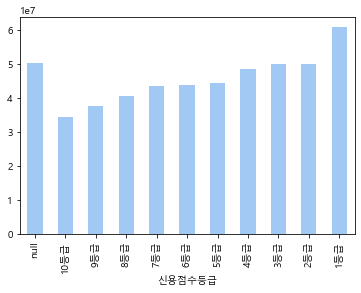

In [777]:
sns.set_palette("pastel")
user_spec.groupby(['신용점수등급'])['연소득'].mean().plot.bar()

## 입사연월 전처리
- 입사년차 계산하여 column 생성
    - 입사연월이 없는 경우 -1로 처리
- 입사연월이 null인 경우는 모두 기타수입이나 사업자

In [778]:
user_spec[user_spec['입사연월'].isnull()]['근로형태'].value_counts()

OTHERINCOME        91556
EARNEDINCOME           4
PRIVATEBUSINESS        3
Name: 근로형태, dtype: int64

7명의 입사연월을 각 유저의 생년월일, 성별이 동일한 유저들의 입사연월 중 최빈값으로 대체


In [779]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])
user_list = list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='EARNEDINCOME')]['유저_번호'].index)+list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='PRIVATEBUSINESS')]['유저_번호'].index)
for i in user_list:
    user_spec.iloc[i,8] = no_duplicated_user[(no_duplicated_user['유저_생년월일']==user_spec.iloc[i,2])&(no_duplicated_user['유저_성별']==user_spec.iloc[i,3])]['입사연월'].mode()[0]

In [780]:
#생성일시 datetime으로 변경
user_spec['생성일시_연월'] = user_spec['생성일시'].str[:7]
user_spec['생성일시_연월'] = user_spec['생성일시_연월'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
user_spec['생성일시_연월'] = pd.to_datetime(user_spec['생성일시_연월'],format = '%Y%m')

In [781]:
#입사연월 datetime으로 변경
user_spec['입사연월_연월'] = user_spec['입사연월'].astype(str).str[:6]
user_spec.loc[user_spec['입사연월_연월']=='nan','입사연월_연월'] = '202301'# nan값인 데이터들 처리
user_spec.loc[user_spec['입사연월']]
user_spec['입사연월_연월'] = pd.to_datetime(user_spec['입사연월_연월'],format = '%Y%m')

입사연월이 유저의 생년월일보다 빠른 데이터
- 입사연월이 유저의 생년월일보다 빠른 데이터 중 test_data에 없는 데이터는 삭제
- 입사연월을 각 유저의 생년월일, 성별과 동일한 유저들의 입사연월 중 최빈값으로 대체



In [782]:
user_spec['유저_생년월일'] = pd.to_datetime(user_spec['유저_생년월일'],format = '%Y') #유저 생년월일 datetime으로 변경
temp_list =set(user_spec[user_spec['유저_생년월일']>user_spec['입사연월_연월']]['신청서_번호'])#유저 생년월일이 입사연월보다 빠른 유저 리스트
loan_list = set(loan_result[(loan_result['신청_여부(y)'].isnull())&(loan_result['신청서_번호'].isin(temp_list))]['신청서_번호']) #test 데이터 중 유저 생년월일이 입사연월보다 빠른 유저 리스트
drop_list = temp_list-loan_list

user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
user_spec.reset_index(drop = True,inplace = True)

In [799]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])#중복되지 않은 유저들의 최빈값 사용하여 대체
temp = list(user_spec[user_spec['신청서_번호'].isin(loan_list)].index) #4명
for i in temp:
    user_spec.iloc[i,-1] = no_duplicated_user[(no_duplicated_user['유저_생년월일']==user_spec.iloc[i,2])&(no_duplicated_user['유저_성별']==user_spec.iloc[i,3])&(no_duplicated_user['근로형태']==user_spec.iloc[i,7])]['입사연월_연월'].mode()[0]

- 입사개월: 생성일시-입사연월  
- 입사나이: 입사연월-생년월일

In [696]:
from datetime import datetime
def diff_month(x): # 입사개월 계산 함수
    return (x[0].year - x[1].year) * 12 + x[0].month - x[1].month 
def diff_year(x): # 입사년차 계산 함수
    return x[0].year - x[1].year

In [811]:
user_spec['입사개월'] = user_spec[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_spec.loc[user_spec['입사개월']<0,+'입사개월'] = '-1'# 입사연월이 없는 otherincome 유저들은 -1로 mapping
user_spec['입사개월'] = user_spec['입사개월'].astype(int)
user_spec['입사나이'] = user_spec[['입사연월_연월','유저_생년월일']].apply(diff_year,axis =1)#입사나이
user_spec.loc[user_spec['입사개월']==-1,'입사나이']=-1#입사연월이 없는 사람들은 입사나이를 -1로 mapping

입사년차가 이상한 데이터
- 입사연월을 정확한 기준을 기점으로 그 이상이라면 위와 같이 처리 기준 논의....

In [823]:
user_spec[user_spec['유저_번호']==858138]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이
886,2009255,858138,1985-01-01,1.0,2022-03-01 07:53:11,910.0,100000000.0,EARNEDINCOME,200302.0,정규직,...,NaN,NaN,3.0,99000000.0,12,1등급,2022-03-01,2003-02-01,229,18.0
11126,1772295,858138,1985-01-01,1.0,2022-03-02 12:33:00,910.0,100000000.0,EARNEDINCOME,200302.0,정규직,...,NaN,NaN,3.0,99000000.0,12,1등급,2022-03-01,2003-02-01,229,18.0
32027,1213914,858138,1985-01-01,1.0,2022-03-04 18:18:31,700.0,100000000.0,EARNEDINCOME,199602.0,정규직,...,NaN,NaN,3.0,99000000.0,12,6등급,2022-03-01,1996-02-01,313,11.0
125602,1275034,858138,1985-01-01,1.0,2022-03-17 14:20:12,700.0,200000000.0,EARNEDINCOME,199602.0,정규직,...,NaN,NaN,3.0,99000000.0,12,6등급,2022-03-01,1996-02-01,313,11.0
187411,433341,858138,1985-01-01,1.0,2022-03-25 17:40:08,700.0,90000000.0,EARNEDINCOME,199602.0,정규직,...,NaN,NaN,3.0,99000000.0,12,6등급,2022-03-01,1996-02-01,313,11.0
353448,1817863,858138,1985-01-01,1.0,2022-04-15 15:50:38,640.0,80000000.0,EARNEDINCOME,199602.0,정규직,...,NaN,NaN,3.0,99000000.0,12,7등급,2022-04-01,1996-02-01,314,11.0
432043,1971916,858138,1985-01-01,1.0,2022-04-25 23:53:34,640.0,80000000.0,EARNEDINCOME,199602.0,정규직,...,0.0,NaN,3.0,99000000.0,12,7등급,2022-04-01,1996-02-01,314,11.0
577613,1033455,858138,1985-01-01,1.0,2022-05-13 15:31:18,640.0,100000000.0,EARNEDINCOME,199602.0,정규직,...,0.0,NaN,3.0,99000000.0,12,7등급,2022-05-01,1996-02-01,315,11.0
688238,28841,858138,1985-01-01,1.0,2022-05-27 06:20:31,640.0,200000000.0,EARNEDINCOME,199602.0,정규직,...,0.0,NaN,3.0,99000000.0,12,7등급,2022-05-01,1996-02-01,315,11.0
872753,2144193,858138,1985-01-01,1.0,2022-06-20 15:55:59,700.0,100000000.0,EARNEDINCOME,19960201.0,정규직,...,0.0,NaN,3.0,99000000.0,12,6등급,2022-06-01,1996-02-01,316,11.0


## 연소득 전처리
1명이 해당되는데 기대출수가 있고 사업자금이 목적인 사람들의 평균 연소득으로 대체

In [830]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])
user_spec.loc[user_spec[user_spec['연소득'].isnull()].index,'연소득']=no_duplicated_user[(no_duplicated_user['대출_목적']=='사업자금')&(no_duplicated_user['기대출수']>0)]['연소득'].mean()
user_spec.reset_index(drop =True,inplace = True)

## 개인회생자_여부,개인회생자_납입_완료_여부 전처리

In [831]:
user_spec.groupby(['개인회생자_여부','개인회생자_납입_완료_여부']).size()

개인회생자_여부  개인회생자_납입_완료_여부
0.0       0.0               119179
          1.0                    3
1.0       0.0                 4212
          1.0                  625
dtype: int64

개인회생자 여부 0: 개인회생자X, 1: 개인회생자O

개인회생자 납입 완료 여부 0: (개인회생자인 경우) 납입중, 1: 납입완료



## 개인회생자_여부,개인회생자_납입_완료_여부 category
1) 개인회생자 X:0

2) 개인회생자 O
- 납입중:1
- 납입완료:2
    
3) 개인회생자 결측치

In [832]:
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부']==1),'개인회생자_납입_완료_여부']=0 # 개인회생자가 아니면서 납입완료된 유저는 3명 -> 완료여부 0으로 변경
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부'].isnull()),'개인회생자_납입_완료_여부'] = 0

In [833]:
user_spec['개인회생자'] = 10 #null값인 데이터는 처리 못한 상황
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부']==0),'개인회생자'] = 0
user_spec.loc[(user_spec['개인회생자_여부']==1)&(user_spec['개인회생자_납입_완료_여부']==0),'개인회생자'] = 1
user_spec.loc[(user_spec['개인회생자_여부']==1)&(user_spec['개인회생자_납입_완료_여부']==1),'개인회생자'] = 2

In [287]:
# temp = user_spec.groupby(['유저_번호','개인회생자_여부'])['생성일시'].size().reset_index()
# user_list = list(temp[temp['유저_번호'].duplicated()]['유저_번호'])

In [292]:
# user_spec[user_spec['유저_번호'].isin(user_list)].sort_values(['유저_번호', '생성일시'], ascending=[True, True])

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이
578336,2053859,24,1985-01-01,1.0,2022-05-13,640.0,44000000.0,EARNEDINCOME,201710.0,정규직,...,0.0,NaN,3.0,66000000.0,2,7등급,2022-05-01,2017-10-01,55,32.0
591274,146634,24,1985-01-01,1.0,2022-05-16,640.0,44000000.0,EARNEDINCOME,201710.0,정규직,...,1.0,0.0,3.0,66000000.0,2,7등급,2022-05-01,2017-10-01,55,32.0
410606,84870,1790,1999-01-01,1.0,2022-04-22,0.0,33000000.0,EARNEDINCOME,202202.0,정규직,...,NaN,NaN,3.0,19000000.0,13,null,2022-04-01,2022-02-01,2,23.0
455653,1725977,1790,1999-01-01,1.0,2022-04-28,660.0,33000000.0,EARNEDINCOME,202202.0,정규직,...,0.0,0.0,3.0,19000000.0,13,7등급,2022-04-01,2022-02-01,2,23.0
475768,356094,1790,1999-01-01,1.0,2022-05-02,660.0,33000000.0,EARNEDINCOME,202202.0,정규직,...,0.0,0.0,3.0,19000000.0,13,7등급,2022-05-01,2022-02-01,3,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901726,1637978,878308,1997-01-01,1.0,2022-06-23,720.0,75000000.0,FREELANCER,20210201.0,기타,...,0.0,0.0,2.0,106000000.0,55,6등급,2022-06-01,2021-02-01,16,24.0
902178,631033,878308,1997-01-01,1.0,2022-06-23,720.0,75000000.0,FREELANCER,20210201.0,기타,...,0.0,0.0,2.0,106000000.0,55,6등급,2022-06-01,2021-02-01,16,24.0
915112,182680,878308,1997-01-01,1.0,2022-06-25,720.0,75000000.0,FREELANCER,20210201.0,기타,...,0.0,0.0,2.0,106000000.0,55,6등급,2022-06-01,2021-02-01,16,24.0
917581,461726,878308,1997-01-01,1.0,2022-06-25,720.0,75000000.0,FREELANCER,20220201.0,기타,...,0.0,0.0,2.0,106000000.0,55,6등급,2022-06-01,2022-02-01,4,25.0


## 기대출수, 기대출금액 전처리

In [838]:
user_spec.isnull().sum()

신청서_번호                  0
유저_번호                   0
유저_생년월일              2058
유저_성별                2058
생성일시                    0
한도조회_당시_유저_신용점수         0
연소득                     0
근로형태                    0
입사연월                91556
고용형태                    0
주거소유형태                  0
대출희망금액                  0
대출_목적                   0
개인회생자_여부           414880
개인회생자_납입_완료_여부     414880
기대출수               143921
기대출금액              222332
대출비교횟수                  0
신용점수등급                  0
생성일시_연월                 0
입사연월_연월                 0
입사개월                    0
입사나이                 1486
개인회생자                   0
dtype: int64